# Model Selection

## 1 - Setup

### 1.1 - Load Modules/Libraries

In [1]:
import os
import sys
sys.path.append('/Users/joshua/Developer/civetqc')

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from civetqc.data import CivetData, QCRatingsData
from civetqc.model import Model
from civetqc.train import train, get_scores, get_cv_scores
from civetqc.visualize import plot_discrimination_thresholds, plot_permutation_importance

from sklearn.metrics import classification_report

### 1.2 - Define Paths

In [3]:
ROOT_DIR = '/Users/joshua/Developer/civetqc'

In [4]:
DATA_DIR = os.path.join(ROOT_DIR, 'data')
FIGURES_DIR = os.path.join(ROOT_DIR, 'figures')
TABLES_DIR = os.path.join(ROOT_DIR, 'tables')

In [5]:
TRAINING_DATASET_PATH = os.path.join(DATA_DIR, 'processed', 'training_dataset.csv')
TESTING_DATASET_PATH = os.path.join(DATA_DIR, 'processed', 'testing_dataset.csv')

### 1.3 - Set Random Seed for Reproducibility

In [6]:
np.random.seed(0)

## 2 - Training

### 2.1 - Load Training Data

In [7]:
civet_data = CivetData.from_csv(TRAINING_DATASET_PATH)
qc_data = QCRatingsData.from_csv(TRAINING_DATASET_PATH)

### 2.2 - Run Search

In [8]:
searches = train(civet_data.features, qc_data.ratings)

### 2.3 - Assess Cross-Validation Scores

In [9]:
cv_scores = pd.DataFrame(get_cv_scores(searches)).T
cv_scores['Mean'] = round(cv_scores.mean(axis=1), 2)
cv_scores

,0,1,2,3,4,Mean
RandomForestClassifier,0.90,0.90,0.97,0.90,0.97,0.93
GradientBoostingClassifier,0.90,0.88,0.91,0.80,0.92,0.88
SVC,0.94,0.95,0.98,0.83,0.95,0.93


In [10]:
cv_scores.to_csv(os.path.join(TABLES_DIR, 'cv_scores.csv'), index=False)

### 2.4 - Plot Discrimination Thresholds

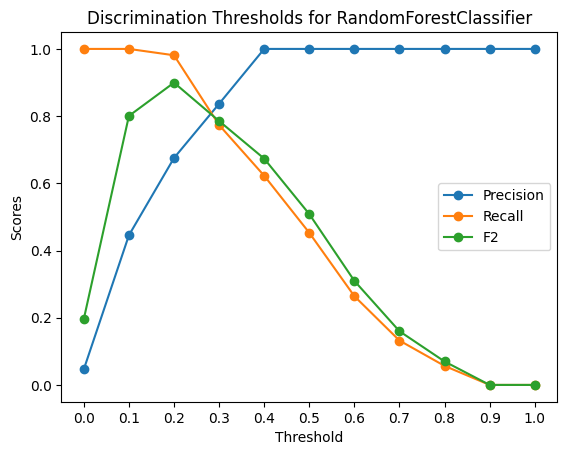

In [11]:
plot_discrimination_thresholds(searches[0], civet_data.features, qc_data.ratings)
plt.savefig(os.path.join(FIGURES_DIR, 'thresholds_rfc.jpeg'), dpi=300)

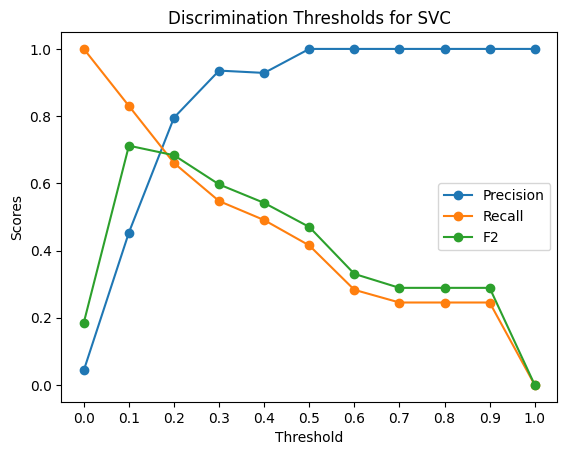

In [12]:
plot_discrimination_thresholds(searches[2], civet_data.features, qc_data.ratings)
plt.savefig(os.path.join(FIGURES_DIR, 'thresholds_svc.jpeg'), dpi=300)

### 2.5 - Adjust Decision Threshold for Random Forest and Save

In [13]:
model = Model(searches[0].best_estimator_, default_threshold=0.2)
model.save()

In [14]:
print(classification_report(qc_data.ratings, model.predict(civet_data.features)))

              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99      1163
         1.0       0.68      0.98      0.80        53

    accuracy                           0.98      1216
   macro avg       0.84      0.98      0.89      1216
weighted avg       0.99      0.98      0.98      1216



## 3 - Feature Importance

In [15]:
model = Model.load()

<AxesSubplot:title={'center':'Permutation Importance (Testing Data)'}, xlabel='Decrease in AUC Score'>

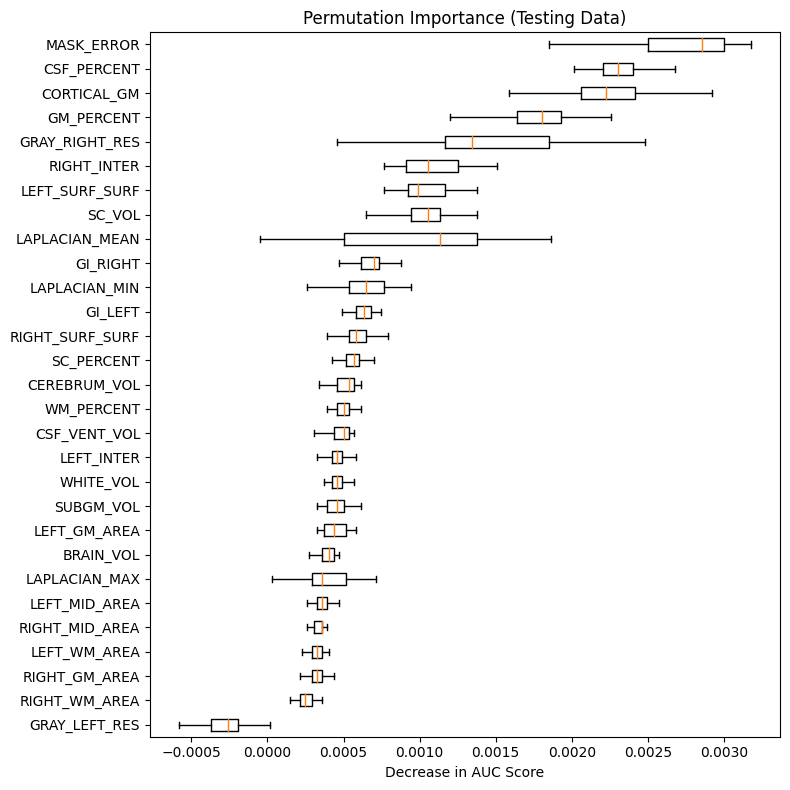

In [16]:
fig, ax = plt.subplots(figsize=[8, 8], tight_layout=True)
plot_permutation_importance(model, civet_data, qc_data, ax)

## 4 - Testing

### 3.1 - Load Testing Data

In [17]:
testing_features = CivetData.from_csv(TESTING_DATASET_PATH).features
testing_target = QCRatingsData.from_csv(TESTING_DATASET_PATH).ratings

### 3.2 - Assess Performance

In [18]:
print(classification_report(testing_target, model.predict(testing_features)))

              precision    recall  f1-score   support

         0.0       1.00      0.95      0.97        98
         1.0       0.81      1.00      0.90        22

    accuracy                           0.96       120
   macro avg       0.91      0.97      0.94       120
weighted avg       0.97      0.96      0.96       120

